# Utility measures for synthetic data before and after the anonymization algorithm is applied.

In [1]:
import pandas as pd
import numpy as np
import itertools

from pointpats import PointPattern
from pointpats.distance_statistics import L

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from pyproj import Proj
from geopy.geocoders import Nominatim

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
train_data = pd.read_csv("Data/synthetic_datasets/train_dataset.csv")

In [3]:
holdout_data = pd.read_csv("Data/synthetic_datasets/holdout_dataset.csv")

In [4]:
sXs_mnl = [pd.read_csv("Data/synthetic_datasets/synthetic_dataset_" + str(i) + ".csv") for i in range(20)]

In [5]:
sXs_cart = [pd.read_csv("Data/synthetic_datasets/cart_synthetic_dataset_" + str(i) + ".csv") for i in range(20)]

In [6]:
sXs_mostly = [pd.read_csv("Data/synthetic_datasets/mostly_synthetic_train_" + str(i) + ".csv") for i in range(20)]

In [7]:
sXs_ks = [pd.read_csv("Data/synthetic_datasets/logistic_ks_synthetic_dataset_" + str(i) + ".csv") for i in range(20)]

***

## Utility Measure 1 - pMSE Ratios

In [8]:
def cart_pmse_ratio(original_data, synthetic_data_sets):
    
    null_pmse_list = []
    
    inds = np.arange(len(synthetic_data_sets))
    
    combo_list = list(itertools.combinations(inds, 2))
    
    for combo in combo_list:
    
        s1 = synthetic_data_sets[combo[0]]
        s2 = synthetic_data_sets[combo[1]]
    
        N_orig = s1.shape[0]
        N_synth = s2.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([s1, s2], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        null_pmse_list.append(pMSE)
    
    pmse_list = []
    
    for s in synthetic_data_sets:
    
        N_orig = original_data.shape[0]
        N_synth = s.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        pmse_list.append(pMSE)
        
    return np.array(pmse_list)/np.mean(null_pmse_list), null_pmse_list

In [9]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
    full_X["age"] = full_X["age"].astype('category')
    
    age_dummies = pd.get_dummies(full_X['age'], drop_first=True)
    
    age_dummies.columns = [str(x) for x in age_dummies.columns]
    
    full_X = full_X.drop("age", axis=1)
    
    full_X = pd.concat([full_X, age_dummies], axis=1)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
    
    full_X = poly.fit_transform(full_X)
    
    full_X = full_X[:,:-36]

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

In [10]:
pmse_ratio(train_data, holdout_data)

1.0402791016045778

In [11]:
# ratios = [pmse_ratio(train_data, Y) for Y in sXs_mnl]
ratios, null_ratios = cart_pmse_ratio(train_data, sXs_mnl)
np.mean(ratios)

1.3023137669840283

In [12]:
ks_rat, null_ratios = cart_pmse_ratio(train_data, sXs_ks)
np.mean(ks_rat)

1.2184711770779715

In [15]:
# cart_ratios = [pmse_ratio(train_data, Y) for Y in sXs_cart]
cart_ratios, null_cart_ratios = cart_pmse_ratio(train_data, sXs_cart)
np.mean(cart_ratios)

1.0231313540256064

In [16]:
# mostly_ratios = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
mostly_ratios, null_mostly_ratios = cart_pmse_ratio(train_data, sXs_mostly)
np.mean(mostly_ratios)

1.2387482358823365

In [17]:
# ratios_holdout = [pmse_ratio(holdout_data, Y) for Y in sXs_mnl]
ratios_holdout, null_holdout = cart_pmse_ratio(holdout_data, sXs_mnl)
np.mean(ratios_holdout)

1.6262754946446667

In [18]:
# cart_ratios_holdout = [pmse_ratio(holdout_data, Y) for Y in sXs_cart]
cart_ratios_holdout, null_cart_holdout = cart_pmse_ratio(holdout_data, sXs_cart)
np.mean(cart_ratios_holdout)

1.3482646032629715

In [19]:
# mostly_ratios_holdout = [pmse_ratio(holdout_data, Y) for Y in sXs_mostly]
mostly_ratios_holdout, null_mostly_holdout = cart_pmse_ratio(holdout_data, sXs_mostly)
np.mean(mostly_ratios_holdout)

1.5280942197424499

***

Compare the null value for the data sets from each synthesis method.

In [21]:
np.mean(null_ratios)

0.061928350976782565

In [22]:
np.mean(null_cart_ratios)

0.07275234921037087

In [23]:
np.mean(null_mostly_ratios)

0.06105098945191431

***

In [40]:
parameters = {'ccp_alpha':np.linspace(1e-20, 1, 100)}

scores = []
params = []
for i,s in enumerate(sXs_mnl):
    clf = GridSearchCV(DecisionTreeClassifier(min_samples_split=20,
                                                   min_samples_leaf=int(np.round(20/3)),
                                                   max_depth=30), parameters, n_jobs=-2)
    
    full = pd.concat([train_data, s], axis=0).reset_index(drop=True)
    
    y = pd.Series(np.repeat([0, 1], repeats=[train_data.shape[0], s.shape[0]]))
    
    clf.fit(X=full, y=y)
    tree_model = clf.best_estimator_
    scores.append(clf.best_score_)
    params.append(clf.best_params_)
    print(i+1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [41]:
scores

[0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753,
 0.4998510796723753]

In [42]:
params

[{'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102},
 {'ccp_alpha': 0.010101010101010102}]

Calculate the null from bootstrapped data sets.

In [27]:
bootstrapped = [train_data.sample(n=train_data.shape[0], replace=True, axis=0) for i in range(20)]

In [28]:
bootstrapped_ratios, bootstrapped_null = cart_pmse_ratio(train_data, bootstrapped)

In [29]:
np.mean(bootstrapped_ratios)

0.38057236556187407

In [31]:
np.mean(bootstrapped_null)

0.034030474125616036

In [33]:
bootstrapped_ratios

array([0.39383855, 0.35823446, 0.31936113, 0.323484  , 0.39807656,
       0.46913283, 0.37628252, 0.40539833, 0.39851474, 0.37095192,
       0.41652716, 0.35523729, 0.29236671, 0.36035645, 0.42405723,
       0.42290803, 0.3882506 , 0.47430337, 0.33758398, 0.32658146])

***

***

What about the pMSE values from a logistic regression?

In [48]:
[pmse_ratio(train_data, x) for x in bootstrapped]

[0.46579533125941625,
 0.43714607159591845,
 0.4160204476875175,
 0.4552830922984766,
 0.4513311720325095,
 0.6423641422945138,
 0.4152167097551342,
 0.6789711185614131,
 0.4057344385248729,
 0.5077162533770706,
 0.5817183636352127,
 0.4763833821102437,
 0.4055127248853728,
 0.3613378064906389,
 0.3517917150543683,
 0.5823409112808192,
 0.5166606088472772,
 0.7287793044390657,
 0.32830949595521686,
 0.35470344105453583]

In [62]:
ratios = [pmse_ratio(train_data, x) for x in sXs_mnl]

In [63]:
ratios_cart = [pmse_ratio(train_data, x) for x in sXs_cart]

In [64]:
ratios_mostly = [pmse_ratio(train_data, x) for x in sXs_mostly]

***

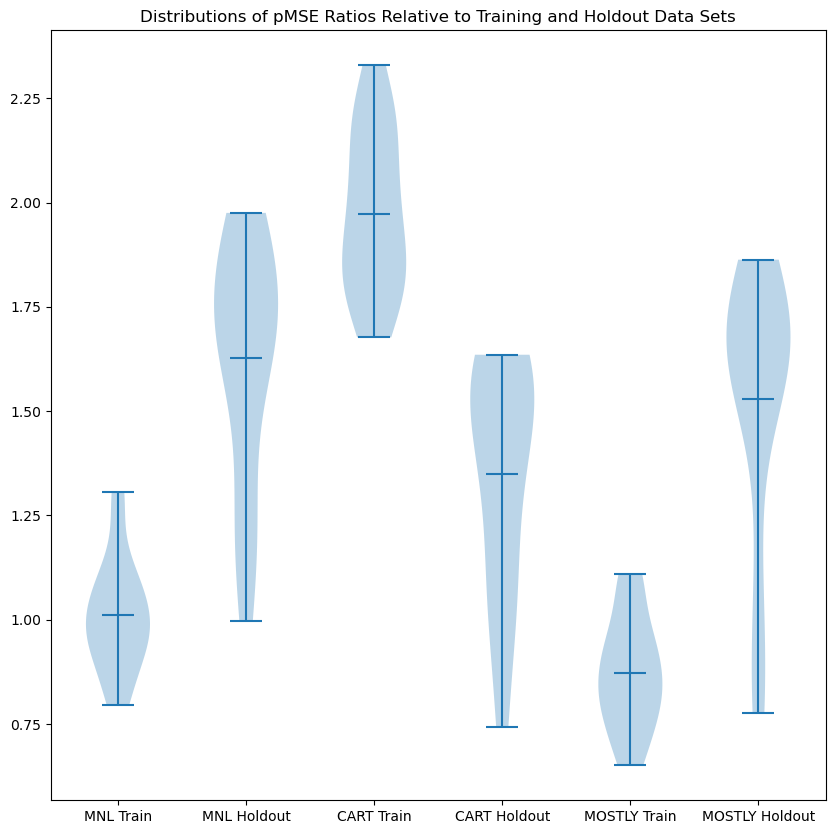

In [66]:
# Combine data
plot_data = list([ratios, ratios_holdout, ratios_cart, cart_ratios_holdout, ratios_mostly, mostly_ratios_holdout])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL Train", "MNL Holdout", "CART Train", "CART Holdout", "MOSTLY Train", "MOSTLY Holdout"]
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of pMSE Ratios Relative to Training and Holdout Data Sets")

plt.show()

***

## Utility Measure 2 - K and L Functions

Calculate L function for original and synthetic datasets and plot.

In [67]:
# L function value for original data
l_orig = L(PointPattern(train_data.loc[:,['latitude', 'longitude']])).l

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [68]:
# L function values for synthetic data
l_synth = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mnl]

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Obje

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [69]:
# L function values for MOSTLY.AI synthetic data
l_mostly = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mostly]

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Obje

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [70]:
# L function values for anonymized synthetic data
l_synth_cart = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart]

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Obje

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [71]:
pos_sXs = [Y.loc[Y.state==1.0,:] for Y in sXs_mnl]

In [72]:
pos_sXs_cart = [Y.loc[Y.state==1.0,:] for Y in sXs_cart]

In [73]:
pos_sXs_mostly = [Y.loc[Y.state==1.0,:] for Y in sXs_mostly]

In [74]:
pos_l_orig = L(PointPattern(train_data.loc[train_data.state==1.0,["latitude", "longitude"]])).l

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [75]:
pos_l_synth = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs]

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Obje

In [76]:
pos_l_synth_cart = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart]

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Obje

In [77]:
pos_l_synth_mostly = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mostly]

C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\Cameron\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Obje

In [78]:
def L_plot(ax1, line_orig, line_synthetic, plot_title):
    
    # x values to plot
    x = np.arange(0, 1.2, 0.1)
    
    # average L function for synthetic data
    synthetic_mean = np.mean(line_synthetic, axis=0)

    # calculate 95% empirical confidence interval for L function value for synthetic data
    qs = np.quantile(line_synthetic, (0.025, 0.975), axis=0)
    
    ax1.plot(x, line_orig, label = 'Original')
    ax1.plot(x, synthetic_mean, label = 'Avg Synthetic')
    ax1.fill_between(x, qs[0,:], qs[1,:], alpha = 0.3)
    ax1.legend(loc = 'lower right')
    ax1.set_title(plot_title)
    ax1.set_xlabel('h')
    ax1.set_ylabel('L(h)')

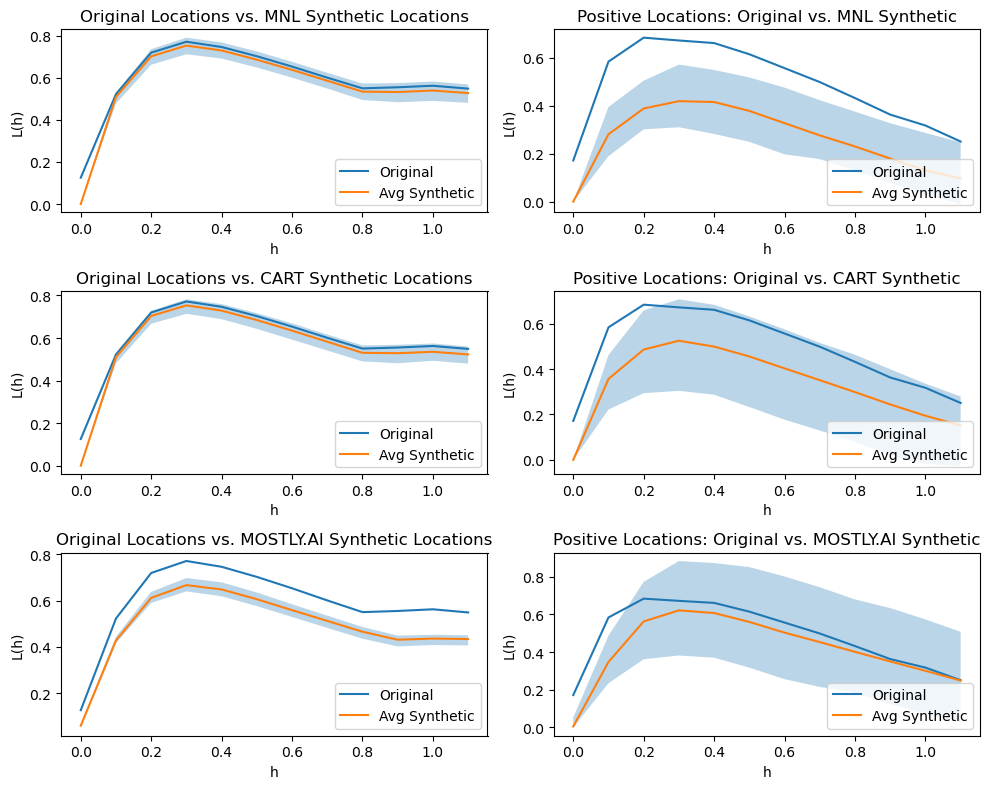

In [79]:
fig, ax = plt.subplots(3, 2, figsize=(10,8))
L_plot(ax[0,0], l_orig, l_synth, "Original Locations vs. MNL Synthetic Locations")
L_plot(ax[0,1], pos_l_orig, pos_l_synth, "Positive Locations: Original vs. MNL Synthetic")
L_plot(ax[1,0], l_orig, l_synth_cart, "Original Locations vs. CART Synthetic Locations")
L_plot(ax[1,1], pos_l_orig, pos_l_synth_cart, "Positive Locations: Original vs. CART Synthetic")
L_plot(ax[2,0], l_orig, l_mostly, "Original Locations vs. MOSTLY.AI Synthetic Locations")
L_plot(ax[2,1], pos_l_orig, pos_l_synth_mostly, "Positive Locations: Original vs. MOSTLY.AI Synthetic")
plt.tight_layout()

# Utility Measure 3: Visual Comparison of Locations

Visual comparison of location distributions.

In [80]:
def scatter_plot(ax1, location_data, plot_title, xlab, ylab):
    
    ax1.scatter(location_data.longitude, location_data.latitude)
    
    ax1.set_title(plot_title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
#     ax1.plot(x, synthetic_mean, label = 'Avg Synthetic')
#     ax1.fill_between(x, qs[0,:], qs[1,:], alpha = 0.3)
#     ax1.legend(loc = 'lower right')
#     ax1.set_title(plot_title)
#     ax1.set_xlabel('h')
#     ax1.set_ylabel('L(h)')

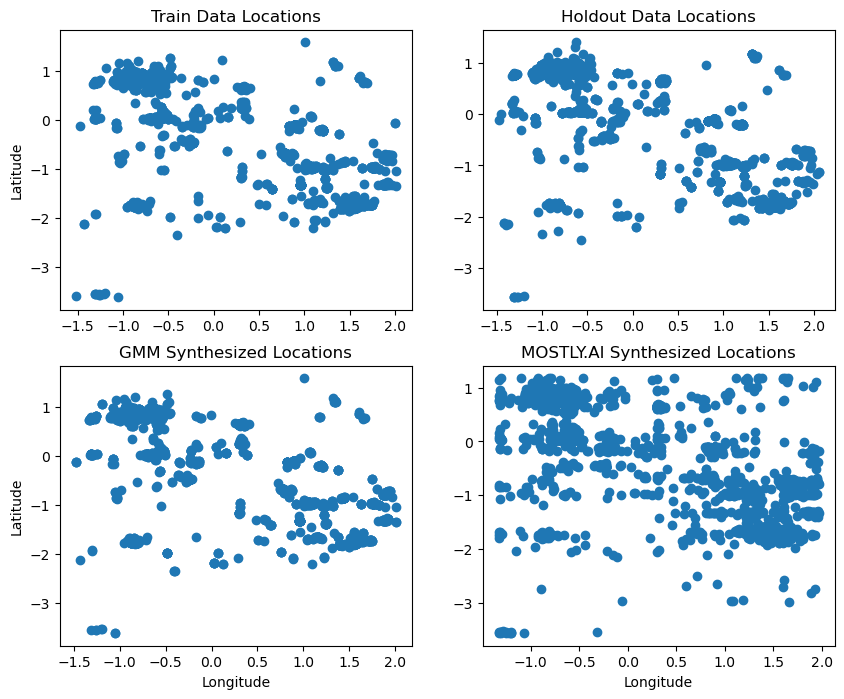

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data, "Train Data Locations", "", "Latitude")
scatter_plot(ax[0,1], holdout_data, "Holdout Data Locations", "", "")
scatter_plot(ax[1,0], sXs_mnl[0], "GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,1], sXs_mostly[0], "MOSTLY.AI Synthesized Locations", "Longitude", "")

***

Look at plots of the points with positive mark values.

TypeError: scatter_plot() missing 2 required positional arguments: 'xlab' and 'ylab'

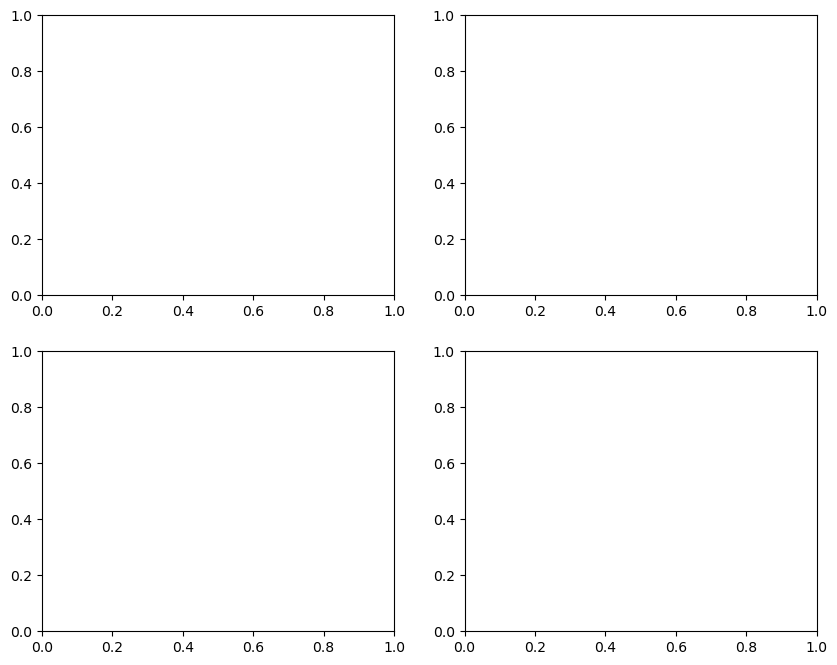

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data.loc[train_data.state==1.0,:], "Train Data Locations")
scatter_plot(ax[0,1], holdout_data.loc[holdout_data.state==1.0,:], "Holdout Data Locations")
scatter_plot(ax[1,0], sXs_mnl[0].loc[sXs_mnl[0].state==1.0,:], "GMM Synthesized Locations")
scatter_plot(ax[1,1], sXs_mostly[0].loc[sXs_mostly[0].state==1.0,:], "MOSTLY.AI Synthesized Locations")

# Utility Measure 4: Absolute Deviations in Cross-Tabulations

Compare this to the utility metric given in the MOSTLY.AI code - I think this would be redundant.

Instead of zip codes, could try discretizing the continuous variables into bins and doing the cross-tabulations that way. Would probably be faster than obtaining zip codes for all the datasets. Check Monika's paper, I think they mention doing this.

Measure the deviations in relative frequencies within cross-tabulations of each variable.

Convert lat/long measurements to zip codes.

Write a function to convert lat/lon measurements into zipcodes.

In [ ]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']

In [ ]:
def zip_generator(dataset, standardization_stats):
    
    # use to reverse meters into lat/lon
    p = Proj("epsg:5179")
    
    # use to get zip from lat/lon
    geolocator = Nominatim(user_agent='sk-zip-code-conversion')
    
    # reverse transform from meters to lat/lon
    locs = pd.concat([dataset.latitude * stan_stats.stds[0] + stan_stats.means[0], dataset.longitude * stan_stats.stds[1] + stan_stats.means[1]], axis=1)
    inverse_locs = pd.DataFrame(p(locs["longitude"], locs["latitude"], inverse=True)).T
    inverse_locs.columns = ["longitude", "latitude"]
    
    # get zips from lat/lon
    zipcodes = inverse_locs.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')
    
    # use nearest neighbor locations to fill in missing zip codes
    no_code = ['postcode' not in x for x in zipcodes]
    has_code = ['postcode' in x for x in zipcodes]
    
    no_code_points = dataset.loc[no_code,["latitude","longitude"]]
    code_points = dataset.loc[has_code,["latitude","longitude"]]
    
    has_code_tree = cKDTree(code_points)
    dists, ids = has_code_tree.query(x=no_code_points, k=1, p=2.0)
    
    missing_zips = [zipcodes[i]['postcode'] for i in ids]
    zips = pd.Series([x['postcode'] if 'postcode' in x else 0 for x in zipcodes])
    zips[no_code_points.index] = missing_zips
    zips.name = "zip"
    
    new_dataset = pd.concat([dataset, zips], axis=1)
    
    return new_dataset

In [ ]:
stan_stats = pd.read_csv("Data/standardization_stats.csv")

In [ ]:
X = zip_generator(X, stan_stats)

## Start with One Way Tables

In [ ]:
def table_maker(data, row_vars, col_vars):
    
    tab = pd.crosstab([data[v] for v in row_vars], [data[v] for v in col_vars], normalize=True, dropna=False)
    
    return tab

Calculate baseline tables for original data.

In [ ]:
sX = sXs[0]

In [ ]:
age = table_maker(X, ['age', 'sex'], ['age'])
# state = table_maker(X.state, X.state)
# sex = table_maker(X.sex, X.sex)
# zip_code = table_maker(X.zip, X.zip)

In [ ]:
age

In [ ]:
s_age = table_maker(sX.age, sX.age)

In [ ]:
s_age

In [ ]:
age

In [ ]:
np.diag(age-s_age)

Get list of all zip codes in south korea, see if I can cross tabulate against that to account for possibly non-overlapping zip codes in the original and synthetic datasets.